In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import time
import os
import tflearn
from utils import *
os.environ["CUDA_VISIBLE_DEVICES"]='1'
mnist_data = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
inputs = tf.placeholder(tf.float32, [None, 28, 28, 1], name='inputs')
targets = tf.placeholder(tf.float32, [None, 3], name='targets')
input_shortcut = tf.placeholder(tf.float32, [None, 2], name='input_shortcut')
train_flag = tf.placeholder(tf.bool, name='training')


net = tflearn.conv_2d(inputs, 64, 3, activation='relu', bias=False)
# Residual blocks
net = tflearn.residual_bottleneck(net, 3, 16, 64)
net = tflearn.residual_bottleneck(net, 1, 32, 128, downsample=True)
net = tflearn.residual_bottleneck(net, 2, 32, 128)
net = tflearn.residual_bottleneck(net, 1, 64, 256, downsample=True)
net = tflearn.residual_bottleneck(net, 2, 64, 256)
net = tflearn.batch_normalization(net)
net = tflearn.activation(net, 'relu')
net = tflearn.global_avg_pool(net)

net = tflearn.fully_connected(net, 200, activation='relu')
feature_transform = tflearn.fully_connected(net, 2, activation='relu')
output = dense_custom(tf.cond(train_flag, lambda: feature_transform,
                              lambda: input_shortcut),
                      2, 3, activation=None)

#This part is for computing the accuracy of this model
pred_y = tf.nn.softmax(output)
pred_y_true = tf.argmax(pred_y, 1)
y_true = tf.argmax(targets, 1)
correct_prediction = tf.equal(pred_y_true, y_true)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# loss function and optimizer
cost = tf.reduce_mean((tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=targets)))

step_adam = tf.train.AdamOptimizer(1e-4).minimize(cost)
step_momentum = tf.train.MomentumOptimizer(0.001, 0.9).minimize(cost)
step_gd = tf.train.GradientDescentOptimizer(0.0001).minimize(cost)

all_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
last_layer_variables = filter(lambda x: 'Variable' in x.name, all_variables)
previous_layer_variables = filter(lambda x: 'Variable' not in x.name, all_variables)

step_sgd_previous_layer = tf.train.GradientDescentOptimizer(0.0001).minimize(cost,
                        var_list = previous_layer_variables)

optimizer_sgd_last_layer = tf.train.GradientDescentOptimizer(1e-4)
step_sgd_last_layer = optimizer_sgd_last_layer.minimize(cost,
                        var_list = last_layer_variables)
optimizer_m_last_layer = tf.train.MomentumOptimizer(1e-4, 0.9)
step_m_last_layer = optimizer_m_last_layer.minimize(cost,
                        var_list = last_layer_variables)


# optimizer = tf.train.MomentumOptimizer(0.0001, 0.9).minimize(cost)
saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))

config = tf.ConfigProto()
config.log_device_placement=False
config.allow_soft_placement=True
config.gpu_options.allow_growth=True
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())

In [3]:
def get_3_class(imgs, labs):
    label = np.argmax(labs,1)
    index_0 = np.where(label==0)[0]
    index_1 = np.where(label==1)[0]
    index_2 = np.where(label==2)[0]
    index = list(index_0)+list(index_1)+list(index_2)
    images = imgs[index]
    label = label[index]
    label = to_categorical(label, 3)
    return images, label

In [4]:
batch_size = 4096
def optmizer(optimizer_step, epochs):

    for i in (range(epochs)):
        epoch_loss = []
        start_epoch = time.time()
        for ii in range(mnist_data.train.num_examples//batch_size):
            batch = mnist_data.train.next_batch(batch_size)
            imgs = batch[0].reshape((-1, 28, 28, 1))
            labs = batch[1]
            imgs, labs = get_3_class(imgs, labs)

            dict_input = {inputs:imgs, targets:labs, train_flag: True, 
                         input_shortcut: np.zeros([batch_size, 2])}

            c, _ = session.run([cost, optimizer_step], feed_dict=dict_input)
            epoch_loss.append(c)
        print("Epoch: {}/{}".format(i+1, epochs), "| Training accuracy: ", session.run(accuracy, feed_dict=dict_input), 
              "| Cost: {}".format(np.mean(epoch_loss)), " | Time for epoch: {:.2f}s".format(time.time() - start_epoch))
        if i%100==0:
            saver.save(session,'../model/mnist_resnet_3_class_{}.ckpt'.format(i))

In [ ]:
optmizer(step_gd, 1000000)

In [16]:
# try adam
optmizer(step_adam, 201)

('Epoch: 1/201', '| Training accuracy: ', 1.0, '| Cost: 0.000515692809131', ' | Time for epoch: 12.03s')
('Epoch: 2/201', '| Training accuracy: ', 0.99999994, '| Cost: 0.000675846880767', ' | Time for epoch: 11.88s')
('Epoch: 3/201', '| Training accuracy: ', 1.0, '| Cost: 0.000536284525879', ' | Time for epoch: 11.91s')
('Epoch: 4/201', '| Training accuracy: ', 1.0000001, '| Cost: 0.00054073962383', ' | Time for epoch: 12.17s')
('Epoch: 5/201', '| Training accuracy: ', 0.9999999, '| Cost: 0.000501732283738', ' | Time for epoch: 12.04s')
('Epoch: 6/201', '| Training accuracy: ', 1.0, '| Cost: 0.000560976564884', ' | Time for epoch: 12.00s')
('Epoch: 7/201', '| Training accuracy: ', 1.0000001, '| Cost: 0.000494885258377', ' | Time for epoch: 12.01s')
('Epoch: 8/201', '| Training accuracy: ', 1.0, '| Cost: 0.000458351132693', ' | Time for epoch: 12.12s')
('Epoch: 9/201', '| Training accuracy: ', 1.0, '| Cost: 0.000419368094299', ' | Time for epoch: 12.22s')
('Epoch: 10/201', '| Training a

('Epoch: 77/201', '| Training accuracy: ', 1.0, '| Cost: 5.7414836192e-05', ' | Time for epoch: 12.07s')
('Epoch: 78/201', '| Training accuracy: ', 1.0, '| Cost: 5.77131650061e-05', ' | Time for epoch: 11.99s')
('Epoch: 79/201', '| Training accuracy: ', 1.0, '| Cost: 5.60211228731e-05', ' | Time for epoch: 12.28s')
('Epoch: 80/201', '| Training accuracy: ', 0.99999994, '| Cost: 5.69725270907e-05', ' | Time for epoch: 12.16s')
('Epoch: 81/201', '| Training accuracy: ', 0.9999999, '| Cost: 5.39762331755e-05', ' | Time for epoch: 12.05s')
('Epoch: 82/201', '| Training accuracy: ', 0.99999994, '| Cost: 5.07405857206e-05', ' | Time for epoch: 12.07s')
('Epoch: 83/201', '| Training accuracy: ', 1.0, '| Cost: 5.04550043843e-05', ' | Time for epoch: 12.02s')
('Epoch: 84/201', '| Training accuracy: ', 0.99999994, '| Cost: 4.9608759582e-05', ' | Time for epoch: 12.02s')
('Epoch: 85/201', '| Training accuracy: ', 1.0, '| Cost: 4.95042913826e-05', ' | Time for epoch: 12.02s')
('Epoch: 86/201', '| 

('Epoch: 152/201', '| Training accuracy: ', 1.0000001, '| Cost: 1.65399869729e-05', ' | Time for epoch: 12.20s')
('Epoch: 153/201', '| Training accuracy: ', 1.0, '| Cost: 1.62470078067e-05', ' | Time for epoch: 12.06s')
('Epoch: 154/201', '| Training accuracy: ', 0.99999994, '| Cost: 1.46146730913e-05', ' | Time for epoch: 12.01s')
('Epoch: 155/201', '| Training accuracy: ', 1.0, '| Cost: 1.50417035911e-05', ' | Time for epoch: 12.02s')
('Epoch: 156/201', '| Training accuracy: ', 0.99999994, '| Cost: 1.58408674906e-05', ' | Time for epoch: 12.08s')
('Epoch: 157/201', '| Training accuracy: ', 1.0, '| Cost: 1.50476735143e-05', ' | Time for epoch: 12.03s')
('Epoch: 158/201', '| Training accuracy: ', 1.0, '| Cost: 1.50995383592e-05', ' | Time for epoch: 12.04s')
('Epoch: 159/201', '| Training accuracy: ', 1.0, '| Cost: 1.52012980834e-05', ' | Time for epoch: 12.04s')
('Epoch: 160/201', '| Training accuracy: ', 0.99999994, '| Cost: 1.43790930451e-05', ' | Time for epoch: 12.25s')
('Epoch: 1

In [17]:
def plot_temp_all_3(feature, label, feature_t, label_t, 
                    name=None):
    pylab.figure()
    red = feature[label == 0]
    blue = feature[label == 1]
    c = feature[label == 2]
    green = feature_t[label_t == 0]
    black = feature_t[label_t == 1]
    yellow = feature_t[label_t == 2]

    pylab.plot(red[:, 0], red[:, 1], 'r.')
    pylab.plot(blue[:, 0], blue[:, 1], 'b.')
    pylab.plot(c[:, 0], c[:,1], 'c.')
    pylab.plot(green[:, 0], green[:, 1], 'g.')
    pylab.plot(black[:, 0], black[:, 1], 'k.')
    pylab.plot(yellow[:, 0], yellow[:, 1], 'y.')
    pylab.xticks(fontsize=17)
    pylab.yticks(fontsize=17)
    if name==None:
        pylab.show()
    else:
        pylab.savefig(name)
def plot_blobs_3(feature, label, name=None):
    pylab.figure()
    red = feature[label == 0]
    blue = feature[label == 1]
    green = feature[label == 2]
    pylab.plot(red[:, 0], red[:, 1], 'g.')
    pylab.plot(blue[:, 0], blue[:, 1], 'k.')
    pylab.plot(green[:, 0], green[:, 1], 'y.')
    pylab.xticks(fontsize=17)
    pylab.yticks(fontsize=17)
    pylab.show()

def random_points_3(start_x, end_x, start_y, end_y, size, random_state):
	np.random.seed(random_state)
	x1 = np.random.uniform(start_x, end_x, size)
	x2 = np.random.uniform(start_y, end_y, size)
	feature =  np.vstack([x1,x2]).transpose()
	label = np.random.choice(3,size)
	return feature, label

def get_svm(feature, label):
    from sklearn.svm import LinearSVC
    clf = LinearSVC(multi_class='ovr')
    clf.fit(feature, label)
    return clf

In [18]:
batch_size_test = 4096
# def get_transform_feature():
feature_t = []
label_t = []
for ii in range(mnist_data.train.num_examples//batch_size_test):
    batch = mnist_data.train.next_batch(batch_size_test)
    imgs = batch[0].reshape((-1, 28, 28, 1))
    labs = batch[1]
    imgs, labs = get_3_class(imgs, labs)
    label_t.append(labs)
    feature_t.append(
        session.run(feature_transform, 
                    feed_dict={inputs:imgs, targets:labs, 
                               train_flag: True, 
                               input_shortcut: np.zeros([batch_size, 2])}))
label_t = np.concatenate(label_t, 0)
label_t = np.argmax(label_t, 1)
feature_t = np.concatenate(feature_t, 0)


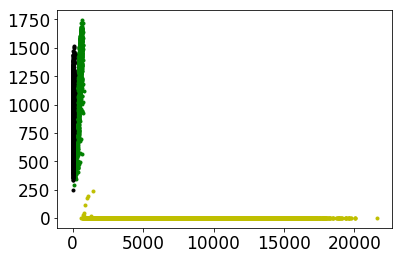

In [19]:
plot_blobs_3(feature_t, label_t)

# transformed space

In [20]:
feature_random, label_random = random_points_3(-100,
    1300,-100,600, 30000,
    random_state=100)
label_random = to_categorical(label_random, 2)
pre_label_nn= session.run(
    pred_y_true,
    feed_dict={inputs:imgs, 
               targets:label_random,
               train_flag: False, 
               input_shortcut: feature_random})

clf = get_svm(feature_t, label_t)
pre_label_svm = clf.predict(feature_random)


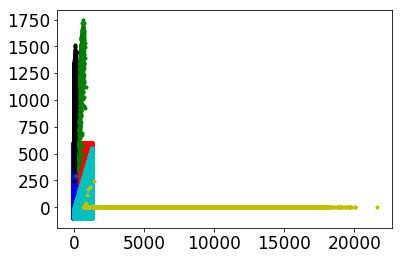

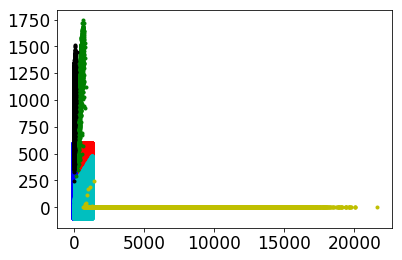

In [21]:
plot_temp_all_3(feature_random, pre_label_nn,feature_t, label_t)
plot_temp_all_3(feature_random, pre_label_svm,feature_t, label_t)

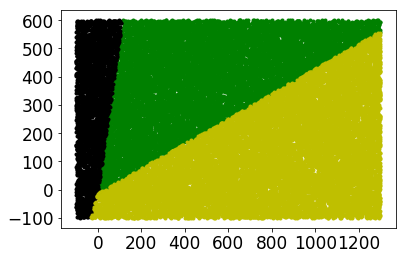

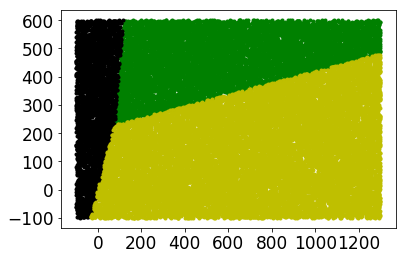

In [22]:
plot_blobs_3(feature_random, pre_label_nn)
plot_blobs_3(feature_random, pre_label_svm)

In [85]:
plot_temp_all_3(feature_random, pre_label_nn,feature_t, label_t, '../result/adam_3_class/nn_transformed.png')
plot_temp_all_3(feature_random, pre_label_svm,feature_t, label_t, '../result/adam_3_class/svm_transformed.png')